# In this Project, we will attempt to classify messages as either spam or not

We have our training data in a csv file. Messages and it's correspoding Lable

In [2]:
#importing the required library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#let's get the content of the message
messages = pd.read_csv('SMSSpamCollection.csv', sep='\t',names=['Label','Message'])
messages.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
#Let's get details of the data
messages.groupby('Label').describe()

Message                                                               
        count unique                                                top freq
Label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

The data has 4825 non spam and 747 as spam. We have "Sorry, I'll call later" as the most frequent no spam message and others details can be found above

Let's get the length of each message

In [5]:
messages['length'] = messages['Message'].apply(len)
messages.head()

,Label,Message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Let's check the distribution of data with respect to the length

In [6]:
#importing the seaborn Library
import seaborn as sns
sns.set_style('whitegrid')

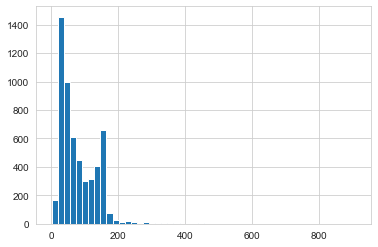

In [7]:
messages['length'].hist(bins=50)

The chart above indicates the majority of the mesages have length less than 200

In [8]:
#let's get more information from the message length
messages['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

There is a message with a length of 910 which is the maximum. Let's get the message

In [9]:
messages[messages['length'] == 910]['Message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

But can we guess if a message is a spam or by just it's length?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018F5DF721C8>,
      dtype=object)

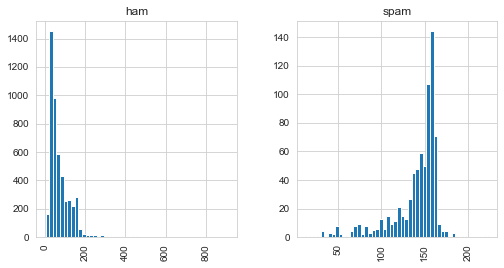

In [10]:
messages.hist(column='length', by='Label', bins=50, figsize=(8,4))

We can see that spam messages have more characters than non spam messages

# The next step is to process the texts in the messages

It is ideal to remove punctuations and some common words in english languages from each message because they will only increase our computation space and time. They aren't useful for our model

In [12]:
import string

In [13]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
#importing list of common words in the nltk library
from nltk.corpus import stopwords
#first ten common words in the library
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [15]:
#Let's now define the function for the process
def data_process(text):
    remove_puc = [ch for ch in text if ch not in string.punctuation]
    remove_puc = ''.join(remove_puc).split()
    return [txt for txt in remove_puc if txt.lower() not in stopwords.words('english')]

In [16]:
data_process('It is ideal to remove punctuations and some common words')

['ideal', 'remove', 'punctuations', 'common', 'words']

# The next step is Vectorization

We convert the messages into a vector the SciKit Learn's algorithm models can work with.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
bag = CountVectorizer(analyzer=data_process).fit(messages['Message'])

To clearify the above step. We extracted all the messages from the Message column. The messages were concatenated and any duplicated words were removed. Now each unique word forms a column against the initial Message column. We then pass the process through a transformer, that way, we compare the number of occurance of each message against those unique words.

In [21]:
#Let's use the 4th message for an example
mess4 = messages['Message'][3]
mess4

'U dun say so early hor... U c already then say...'

Let's transform the message to see what happens

In [22]:
bag4 = bag.transform([mess4])
print(bag4)
print(bag4.shape)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


The above indicates that there are 7 unique words in the message and we have 11425 unique words in all the messages. Let's get the words with two occurance

In [24]:
print(bag.get_feature_names()[4068])
print(bag.get_feature_names()[9554])

U
say


Now we will work on all the messages

In [25]:
messages_bag = bag.transform(messages['Message'])

In [26]:
#let's get some other features
print('Shape of Sparse Matrix: ', messages_bag.shape)
print('Amount of Non-Zero occurences: ', messages_bag.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


In [27]:
sparsity = (100.0 * messages_bag.nnz / (messages_bag.shape[0] * messages_bag.shape[1]))
print(f'sparsity: {sparsity}')

sparsity: 0.07940295412668218


# Term Frequency Inverse Document Frequecy TF-IDF

First we get the term frequency(tf). Considering the message 'U dun say so early hor... U c already then say...' used above. The term frquency of 'say' would be 2/9 because 'say' occured twice and the words 'so' and 'then' would be ignored because they are common words. This leaves us with 9 words. Now for the inverse document frequency(idf), we get the logarithm of the total unique words which in our case is 11425 divided by the total number of occurance of 'say' against all messages (we sum all non zero rows in the 'say' column). We now multiply tf with idf to get the tf-idf

In [28]:
from sklearn.feature_extraction.text import TfidfTransformer

In [29]:
#As an example let's get the tf-idf of the 4th message
tfidf_transformer = TfidfTransformer().fit(messages_bag)
tfidf4 = tfidf_transformer.transform(bag4)
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


In [31]:
#Now we work on all the messages
messages_tfidf = tfidf_transformer.transform(messages_bag)

# Now we Train the Model

In [32]:
#We will use the naive bayes classifier
from sklearn.naive_bayes import MultinomialNB

In [33]:
spam_model = MultinomialNB()
spam_model.fit(messages_tfidf, messages['Label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [34]:
predictions = spam_model.predict(messages_tfidf)

In [35]:
#Let's determine the accuracy of our classifier
from sklearn.metrics import classification_report

In [36]:
print(classification_report(messages['Label'], predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



Interesting. judging by the f1-score, we can see that our model did pretty well.

We wouldn't rejoice yet because we tested our model against the exact trained data. We need to evaluate our model performance based on data it hasn't seen. So, we need to split our data into training and testing sets. Luckly we have that included in the sklearn library

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(messages['Message'], messages['Label'], test_size=0.2, random_state=42)

# Working with Pipeline

We could use a pipeline to combine and simplify the above processes

In [39]:
from sklearn.pipeline import Pipeline

In [40]:
pipeline = Pipeline([
    ('bag', CountVectorizer(analyzer=data_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [41]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bag',
                 CountVectorizer(analyzer=<function data_process at 0x0000018F5F47E3A8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [42]:
predictions = pipeline.predict(X_test)

In [43]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

         ham       1.00      0.97      0.98      1001
        spam       0.77      1.00      0.87       114

    accuracy                           0.97      1115
   macro avg       0.88      0.98      0.92      1115
weighted avg       0.98      0.97      0.97      1115



We haven't done a bad job as our model can predict 87% of spam messages

Let's introduce a simple GUI
We will make use of a library called Traits. Note: traits has to be installed (using pip install)

In [44]:
from traits.api import HasTraits, Str, Range, Enum, Int
from traitsui.api import Item, RangeEditor, View, Label

In [66]:
class Detector(HasTraits):
    text = Str

detector = Detector()

Detector_view = View(
    Label("Pass your message into our detector"),
    Item('text',width = 480,height = 30),
    buttons=['OK', 'Cancel'],
    title = 'Spam Message Detector',
    resizable = True
)
detector.configure_traits(view=Detector_view)

True

In [52]:
def correct(s):
    if s == 'ham':
        return 'NOT A SPAM'
    return 'A SPAM'

In [69]:
class Display(HasTraits):
    name = Str('search here')

display = Display()

if detector.configure_traits(view=Detector_view):
    display = Display()
    
    result = correct(pipeline.predict([detector.text])[0])
    
    Display_view = View(
    Label('This message is '+result, height = 40),
    buttons=['OK', 'Cancel'],
    title = 'Spam Detector',
    resizable = True
    )
    display.configure_traits(view=Display_view)

# Thank You